# Wide-field imaging demonstration

This script makes a fake data set, fills it with a number of point components, and then images it using a variety of algorithms. See imaging-fits for a similar notebook that checks for errors in the recovered properties of the images.

The measurement equation for a wide field of view interferometer is:

$$V(u,v,w) =\int \frac{I(l,m)}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um + w(\sqrt{1-l^2-m^2}-1))} dl dm$$

We will show various algorithms for computing approximations to this integral. Calculation of the visibility $V$ from the sky brightness $I$ is called {\bf predict}, and the inverese is called {\bf invert}.

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join('..','..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (18.0, 18.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from arl.data.polarisation import PolarisationFrame
from arl.visibility.base import create_visibility, create_visibility, create_visibility_from_rows
from arl.skycomponent.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, create_w_term_like
from arl.image.iterators import  image_raster_iter
from arl.visibility.iterators import vis_timeslice_iter, vis_wstack_iter
from arl.util.testing_support import create_named_configuration
from arl.imaging import invert_2d, create_image_from_visibility, \
    predict_skycomponent_visibility, advise_wide_field
from arl.imaging.imaging_context import invert_function, predict_function, imaging_context
from arl.visibility.iterators import vis_timeslice_iter
from arl.imaging.weighting import weight_visibility
import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

doplot = True

In [9]:
from arl import arl_default_args
from arl.data.parameters import set_parameters, get_parameter

arl_default_args('imaging-wterm.ini')

Construct the SKA1-LOW core configuration

In [3]:
lowcore = create_named_configuration('LOWBD2-CORE')

create_configuration_from_file: Maximum radius inf m includes 166 antennas/stations


We create the visibility. 

This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [4]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e7])


reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame("stokesI"))

create_visibility: 95865 rows, 0.010 GB


Advise on wide field parameters. This returns a dictioanry with all the input and calculated variables.

In [5]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels (power of 2, 3) per side = 512
advice_wide_field: W sampling for full image = 0.2 (wavelengths)
advice_wide_field: W sampling for primary beam = 8.7 (wavelengths)
advice_wide_field: Time sampling for full image = 25.2 (s)
advice_wide_field: Time sampling for primary beam = 908.6 (s)
advice_wide_field: Frequency sampling for full image = 29212.6 (Hz)
advice_wide_field: Frequency sampling for primary beam = 1051653.8 (Hz)
advice_wide_field: Number of planes in w st

Plot the synthesized UV coverage.

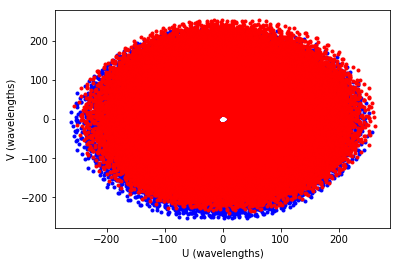

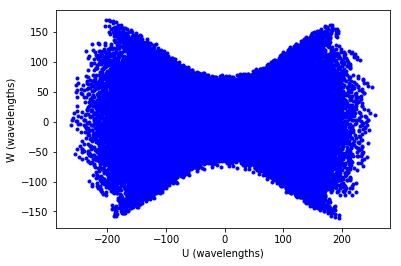

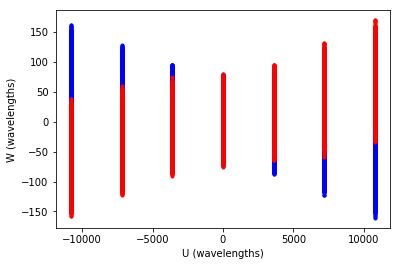

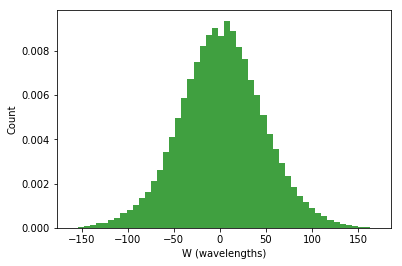

In [6]:
if doplot:
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 1], '.', color='b')
    plt.plot(-vt.data['uvw'][:, 0], -vt.data['uvw'][:, 1], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('V (wavelengths)')
    plt.show()
    
    plt.clf()
    plt.plot(vt.data['uvw'][:, 0], vt.data['uvw'][:, 2], '.', color='b')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('W (wavelengths)')
    plt.show()

    plt.clf()
    plt.plot(vt.data['time'][vt.u>0.0], vt.data['uvw'][:, 2][vt.u>0.0], '.', color='b')
    plt.plot(vt.data['time'][vt.u<=0.0], vt.data['uvw'][:, 2][vt.u<=0.0], '.', color='r')
    plt.xlabel('U (wavelengths)')
    plt.ylabel('W (wavelengths)')
    plt.show()

    plt.clf()
    n, bins, patches = plt.hist(vt.w, 50, normed=1, facecolor='green', alpha=0.75)
    plt.xlabel('W (wavelengths)')
    plt.ylabel('Count')
    plt.show()

Show the planar nature of the uvw sampling, rotating with hour angle

/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)
/Users/timcornwell/anaconda/envs/arlenv/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


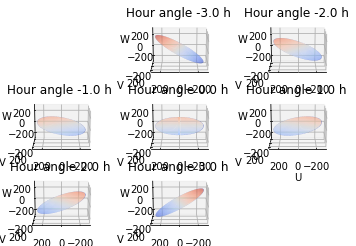

In [7]:
if doplot:
    rmax = numpy.sqrt(numpy.max(vt.u**2+vt.v**2+vt.w**2))
    u = numpy.linspace(-rmax, rmax, 1000)
    v = numpy.linspace(-rmax, rmax, 1000)
    u, v = numpy.meshgrid(u, v)
 
    skip=10
    from arl.imaging.timeslice import fit_uvwplane_only
    from matplotlib import cm, colors
    fig=plt.figure()
    for i, rows in enumerate(vis_timeslice_iter(vt)):
        vis_slice = create_visibility_from_rows(vt, rows)
        a, b = fit_uvwplane_only(vis_slice)
        wvalues = a*u + b*v
        r = numpy.sqrt(u**2 + v**2)
        wvalues=numpy.where(r<rmax, wvalues, numpy.nan)
        ax = fig.add_subplot(331+1+i, projection='3d')
        norm = colors.Normalize(vmin=-rmax, vmax=+rmax)
        ax.plot_surface(u, v, wvalues, rstride=skip, cstride=skip, cmap=cm.coolwarm, norm=norm)
        ax.set_xlabel('U')
        ax.set_ylabel('V')
        ax.set_zlabel('W')
        ha = vis_slice.time[0]/3600.0
        ax.set_title('Hour angle %.1f h' % ha)
        ax.view_init(15, 90)
        ax.set_xlim(-1.1*rmax,1.1*rmax)
        ax.set_ylim(-1.1*rmax,1.1*rmax)
        ax.set_zlim(-1.1*rmax,1.1*rmax)
    plt.show()

Create a grid of components and predict each in turn, using the full phase term including w.

In [11]:
set_parameters('imaging-wterm.ini', {'facets':4}, 'imaging')

npixel = 512
cellsize=0.001
facets = 4
flux = numpy.array([[100.0]])
vt.data['vis'] *= 0.0

model = create_image_from_visibility(vt, npixel=512, cellsize=0.001, polarisation_frame=PolarisationFrame("stokesI"))
spacing_pixels = npixel // facets
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = 180.0 * cellsize * spacing_pixels / numpy.pi
centers = -1.5, -0.5, +0.5, +1.5
comps=list()
for iy in centers:
    for ix in centers:
        pra =  int(round(npixel // 2 + ix * spacing_pixels - 1))
        pdec = int(round(npixel // 2 + iy * spacing_pixels - 1))
        sc = pixel_to_skycoord(pra, pdec, model.wcs)
        log.info("Component at (%f, %f) %s" % (pra, pdec, str(sc)))
        comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                   polarisation_frame=PolarisationFrame("stokesI"))
        comps.append(comp)
predict_skycomponent_visibility(vt, comps)

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 128
Component at (63.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (34.54072794, -54.75874632)>
Component at (191.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (21.67016023, -55.97155392)>
Component at (319.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (8.53437599, -55.98101975)>
Component at (447.000000, 63.000000) <SkyCoord (ICRS): (ra, dec) in deg
    (355.65593443, -54.78677607)>
Component at (63.000000, 191.000000) <SkyCoord (ICRS): (ra, dec) in deg

Make the dirty image and point spread function using the two-dimensional approximation:

$$V(u,v,w) =\int I(l,m) e^{2 \pi j (ul+um)} dl dm$$

Note that the shape of the sources vary with position in the image. This space-variant property of the PSF arises from the w-term neglected in the two-dimensional invert.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
weight_gridding: Performing uniform weighting
Max, min in dirty image = 47.106564, -8.522345, sumwt = 0.018298


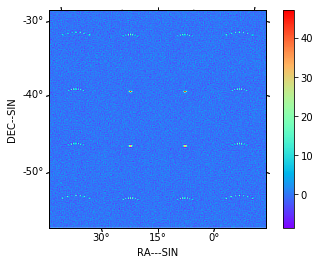

In [13]:
dirty = create_image_from_visibility(vt, npixel=512, cellsize=0.001, 
                                     polarisation_frame=PolarisationFrame("stokesI"))
vt, _, _ = weight_visibility(vt, dirty)
dirty, sumwt = invert_function(vt, dirty, context='2d', arl_config='imaging-wterm.ini')

if doplot:
    show_image(dirty)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging-wterm_dirty.fits' % (results_dir))

This occurs because the Fourier transform relationship between sky brightness and visibility is only accurate over small fields of view. 

Hence we can make an accurate image by partitioning the image plane into small regions, treating each separately and then glueing the resulting partitions into one image. We call this image plane partitioning image plane faceting.

$$V(u,v,w) = \sum_{i,j} \frac{1}{\sqrt{1- l_{i,j}^2- m_{i,j}^2}} e^{-2 \pi j (ul_{i,j}+um_{i,j} + w(\sqrt{1-l_{i,j}^2-m_{i,j}^2}-1))}
\int  I(\Delta l, \Delta m) e^{-2 \pi j (u\Delta l_{i,j}+u \Delta m_{i,j})} dl dm$$


create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
raster: predicting using 4 x 4 image partitions
raster: spacing of raster (128, 128)
raster: partition (0, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (34.4144013, -54.71664839)>
raster: partition (1, 0) of (4, 4)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)> to image phasecentre <SkyCoord (ICRS): 

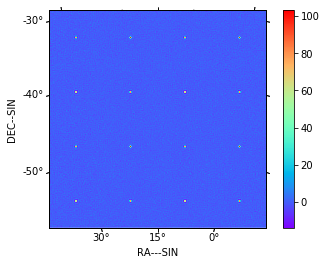

In [15]:
dirtyFacet = create_image_from_visibility(vt, npixel=512, cellsize=0.001, 
                                          polarisation_frame=PolarisationFrame("stokesI"))
dirtyFacet, sumwt = invert_function(vt, dirtyFacet, context='facets', arl_config='imaging-wterm.ini')

if doplot:
    show_image(dirtyFacet)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet.data.max(), dirtyFacet.data.min(), sumwt))
export_image_to_fits(dirtyFacet, '%s/imaging-wterm_dirtyFacet.fits' % (results_dir))

That was the best case. This time, we will not arrange for the partitions to be centred on the sources. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
raster: predicting using 2 x 2 image partitions
raster: spacing of raster (256, 256)
raster: partition (0, 0) of (2, 2)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)> to image phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (26.94754342, -51.80721107)>
raster: partition (1, 0) of (2, 2)
shift_vis_from_image: shifting phasecentre from vis phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)> to image phasecentre <SkyCoord (ICRS):

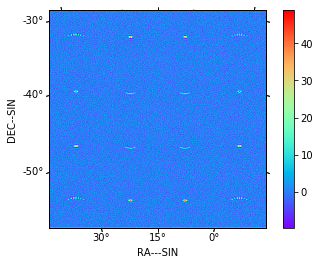

In [16]:
dirtyFacet2 = create_image_from_visibility(vt, npixel=512, cellsize=0.001, 
                                           polarisation_frame=PolarisationFrame("stokesI"))
set_parameters('imaging-wterm.ini', {'facets':2}, 'imaging')
dirtyFacet2, sumwt = invert_function(vt, dirtyFacet2, context='facets', arl_config='imaging-wterm.ini')

if doplot:
    show_image(dirtyFacet2)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyFacet2.data.max(), dirtyFacet2.data.min(), sumwt))
export_image_to_fits(dirtyFacet2, '%s/imaging-wterm_dirtyFacet2.fits' % (results_dir))

Another approach is to partition the visibility data by slices in w. The measurement equation is approximated as:

$$V(u,v,w) =\sum_i \int   \frac{ I(l,m) e^{-2 \pi j (w_i(\sqrt{1-l^2-m^2}-1))})}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um)} dl dm$$

If images constructed from slices in w are added after applying a w-dependent image plane correction, the w term will be corrected. 

The w-dependent w-beam is:

create_w_term_image: For w = 169.6, field of view = 0.512000, Fresnel number = 11.12


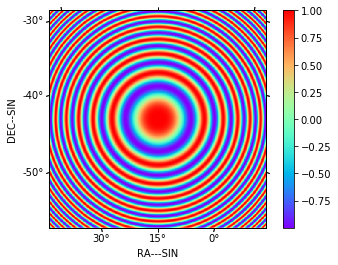

In [17]:
if doplot:
    wterm = create_w_term_like(model, phasecentre=vt.phasecentre, w=numpy.max(vt.w))
    show_image(wterm)
    plt.show()

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = -160.4, field of view = 0.512000, Fresnel number = 10.51
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = -157.2, field of view = 0.512000, Fresnel number = 10.30
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w 

invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = 4.1, field of view = 0.512000, Fresnel number = 0.27
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = 8.1, field of view = 0.512000, Fresnel number = 0.53
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = 12.1, field of view = 0.512000, Fresnel number = 0.79
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = 16.1, field of view = 0.512000, Fresnel number = 1.06
invert_wstack_single: predicting using single w slice
invert_2d: retaining imaginary part of dirty image
create_w_term_image: For w = 20.2, field of view = 0.512000, Fresnel number = 1.32
invert_wstack_single: predicting using single w slice
invert_2

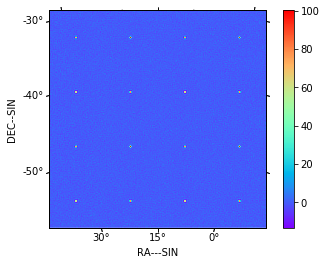

Max, min in dirty image = 100.224539, -13.382161, sumwt = 0.018298


In [21]:
dirtywstack = create_image_from_visibility(vt, npixel=512, cellsize=0.001, 
                                           polarisation_frame=PolarisationFrame("stokesI"))
set_parameters('imaging-wterm.ini', {'padding':2, 'vis_slices':31, 'wstack':4.0}, 'imaging')

dirtywstack, sumwt= invert_function(vt, dirtywstack, context='wstack', arl_config='imaging-wterm.ini')
show_image(dirtywstack)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtywstack.data.max(), dirtywstack.data.min(), sumwt))

export_image_to_fits(dirtywstack, '%s/imaging-wterm_dirty_wstack.fits' % (results_dir))

The w-term can also be viewed as a time-variable distortion. Approximating the array as instantaneously co-planar, we have that w can be expressed in terms of $u,v$

$$w = a u + b v$$

Transforming to a new coordinate system:

$$ l' = l + a (\sqrt{1-l^2-m^2}-1))$$
$$ m' = m + b (\sqrt{1-l^2-m^2}-1))$$

Ignoring changes in the normalisation term, we have:

$$V(u,v,w) =\int \frac{I(l',m')}{\sqrt{1-l'^2-m'^2}} e^{-2 \pi j (ul'+um')} dl' dm'$$

To illustrate this, we will construct images as a function of time. For comparison, we show difference of each time slice from the best facet image. Instantaneously the sources are un-distorted but do lie in the wrong location.

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 193.050761 wavelengths
create_image_from_visibility: Critical cellsize = 0.002590 radians, 0.148396 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 96.449501, -20.331750, sumwt = 0.002330


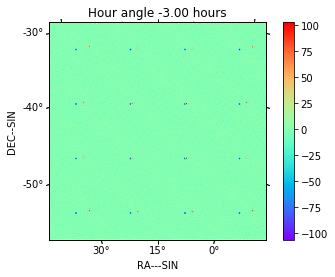

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 231.734708 wavelengths
create_image_from_visibility: Critical cellsize = 0.002158 radians, 0.123624 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 101.622289, -24.048077, sumwt = 0.002574


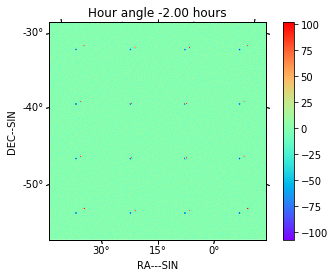

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 255.904441 wavelengths
create_image_from_visibility: Critical cellsize = 0.001954 radians, 0.111948 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 99.160421, -22.960258, sumwt = 0.002810


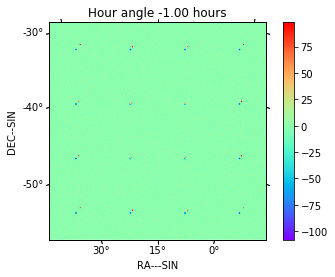

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 103.156940, -27.328258, sumwt = 0.002856


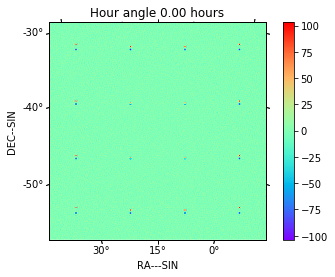

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 253.641975 wavelengths
create_image_from_visibility: Critical cellsize = 0.001971 radians, 0.112946 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 101.501933, -27.497588, sumwt = 0.002785


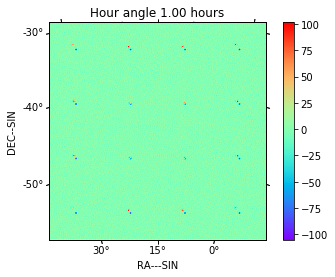

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 236.737485 wavelengths
create_image_from_visibility: Critical cellsize = 0.002112 radians, 0.121011 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 103.951966, -22.887907, sumwt = 0.002600


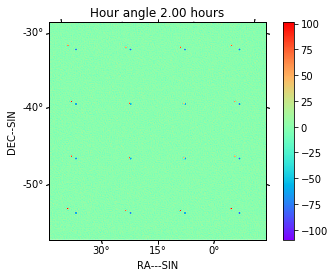

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 204.646182 wavelengths
create_image_from_visibility: Critical cellsize = 0.002443 radians, 0.139987 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Max, min in dirty image = 99.532897, -21.637848, sumwt = 0.002343


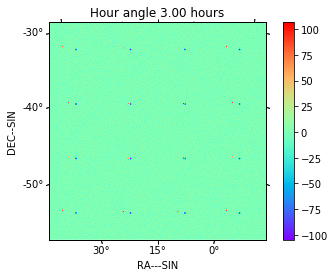

In [24]:
for rows in vis_timeslice_iter(vt):
    visslice = create_visibility_from_rows(vt, rows)
    dirtySnapshot = create_image_from_visibility(visslice, npixel=512, cellsize=0.001, 
                                                 polarisation_frame=PolarisationFrame("stokesI"))
    dirtySnapshot, sumwt = invert_function(visslice, dirtySnapshot, context='2d')
    
    print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
          (dirtySnapshot.data.max(), dirtySnapshot.data.min(), sumwt))
    if doplot:
        dirtySnapshot.data -= dirtyFacet.data
        show_image(dirtySnapshot)
        plt.title("Hour angle %.2f hours" % (numpy.average(visslice.time) * 12.0 / 43200.0))
        plt.show()

This timeslice imaging leads to a straightforward algorithm in which we correct each time slice and then sum the resulting timeslices. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
invert_timeslice: inverting using time slices
fit_uvwplane: Fit to 13695 rows reduces rms w from 59.6 to 0.0 m
invert_timeslice: inverting using time slices
fit_uvwplane: Fit to 13695 rows reduces rms w from 46.1 to 0.0 m
invert_timeslice: inverting using time slices
fit_uvwplane: Fit to 13695 rows reduces rms w from 33.7 to 0.0 m
invert_timeslice: inverting using time slices
fit_uvwplane: Fit to 13695 rows reduces rms w from 28.0 to 0.0 m
invert_timeslice: inverting using time slices
fit_uvwplane: Fit to 136

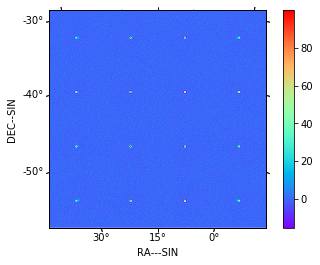

Max, min in dirty image = 99.883699, -15.495151, sumwt = 0.018298


In [28]:
dirtyTimeslice = create_image_from_visibility(vt, npixel=512, cellsize=0.001,
                                             polarisation_frame=PolarisationFrame("stokesI"))
set_parameters('imaging-wterm.ini', {'timeslice':'auto', 'padding':2}, 'imaging')

dirtyTimeslice, sumwt= invert_function(vt, dirtyTimeslice, context='timeslice', arl_config='imaging-wterm.ini')

show_image(dirtyTimeslice)
plt.show()

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % 
      (dirtyTimeslice.data.max(), dirtyTimeslice.data.min(), sumwt))

export_image_to_fits(dirtyTimeslice, '%s/imaging-wterm_dirty_Timeslice.fits' % (results_dir))

Finally we try w-projection. For a fixed w, the measurement equation can be stated as as a convolution in Fourier space. 

$$V(u,v,w) =G_w(u,v) \ast \int \frac{I(l,m)}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um)} dl dm$$

where the convolution function is:

$$G_w(u,v) = \int \frac{1}{\sqrt{1-l^2-m^2}} e^{-2 \pi j (ul+um + w(\sqrt{1-l^2-m^2}-1))} dl dm$$


Hence when gridding, we can use the transform of the w beam to correct this effect while gridding. 

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 9999999.9999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
get_kernel_list: Using wprojection kernel
get_kernel_list: Fresnel number = 65.536000
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: 

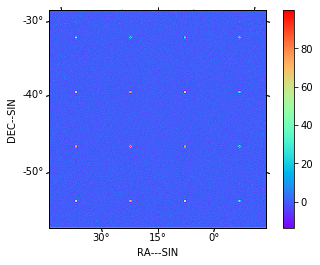

In [29]:
dirtyWProjection = create_image_from_visibility(vt, npixel=512, cellsize=0.001, 
                                                polarisation_frame=PolarisationFrame("stokesI"))
set_parameters('imaging-wterm.ini', {'wstep':advice['w_sampling_primary_beam'], 'padding':1}, 'imaging')

dirtyWProjection, sumwt = invert_function(vt, dirtyWProjection, context='2d',arl_config='imaging-wterm.ini')
if doplot:
    show_image(dirtyWProjection)

print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirtyWProjection.data.max(), 
                                                             dirtyWProjection.data.min(), sumwt))
export_image_to_fits(dirtyWProjection, '%s/imaging-wterm_dirty_WProjection.fits' % (results_dir))
